<a href="https://colab.research.google.com/github/mcgmed/Tensorflow/blob/main/Recurrent-Neural-Networks-for-NLP/Sarcasm_RNN_gloVe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import string
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import zipfile
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

# !wget --no-check-certificate \
#     https://nlp.stanford.edu/data/glove.twitter.27B.zip \
#     -O /tmp/glove.zip

--2022-11-29 19:52:16--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.219.128, 209.85.146.128, 209.85.147.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.219.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2022-11-29 19:52:16 (107 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [63]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

datastore[:3]

[{'article_link': 'https://www.huffingtonpost.com/entry/versace-black-code_us_5861fbefe4b0de3a08f600d5',
  'headline': "former versace store clerk sues over secret 'black code' for minority shoppers",
  'is_sarcastic': 0},
 {'article_link': 'https://www.huffingtonpost.com/entry/roseanne-revival-review_us_5ab3a497e4b054d118e04365',
  'headline': "the 'roseanne' revival catches up to our thorny political mood, for better and worse",
  'is_sarcastic': 0},
 {'article_link': 'https://local.theonion.com/mom-starting-to-fear-son-s-web-series-closest-thing-she-1819576697',
  'headline': "mom starting to fear son's web series closest thing she will have to grandchild",
  'is_sarcastic': 1}]

glove.twitter.27B.25d.txt file is found on Internet and uploaded by hand.

In [39]:
glove_embeddings = dict()
f = open('/tmp/glove.twitter.27B.25d.txt')
for line in f:
  values = line.split()
  word = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  glove_embeddings[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(glove_embeddings))

Loaded 362 word vectors.


In [42]:
glove_embeddings.pop('stop')

array([ 0.11609,  1.0681 , -0.0841 ], dtype=float32)

In [44]:
glove_embeddings['home']

array([-1.0591  ,  0.672   ,  0.63173 , -0.73768 , -0.208   ,  0.34584 ,
        0.97608 , -0.064819,  0.17373 ,  0.3218  , -0.24289 , -0.23366 ,
       -4.7382  ,  0.045759,  0.42937 , -0.53261 ,  0.41289 , -0.55134 ,
       -0.68221 , -0.66009 , -0.47127 , -0.50653 ,  0.30581 ,  0.13673 ,
        0.39416 ], dtype=float32)

In [45]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

sentences = [] 
labels = []
urls = []

for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [46]:
vocab_size = 13200
embedding_dim = 25
max_length = 50
trunc_type='post'
padding_type='post'
oov_tok = ""
training_size = 23000
num_epochs = 30

In [47]:
print(f'Length of sentences: {len(sentences)}')

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index
print(f'Instances from word index: {list(word_index.items())[:6]}')

wc = tokenizer.word_counts
print(f'Instances from word counts: {list(wc.items())[:6]}')

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

Length of sentences: 26709
Instances from word index: [('', 1), ('new', 2), ('trump', 3), ('man', 4), ('not', 5), ('just', 6)]
Instances from word counts: [('former', 90), ('versace', 1), ('store', 44), ('clerk', 9), ('sues', 13), ('secret', 78)]


In [48]:
xs=[]
ys=[]
cumulative_x=[]
cumulative_y=[]
total_y=0
for word, index in tokenizer.word_index.items():
  xs.append(index)
  cumulative_x.append(index)
  if glove_embeddings.get(word) is not None:
    total_y = total_y + 1
    ys.append(1)
  else:
    ys.append(0)
  cumulative_y.append(total_y / index)

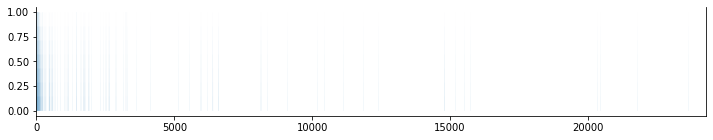

In [49]:
fig, ax = plt.subplots(figsize=(12,2))
ax.spines['top'].set_visible(False)

plt.margins(x=0, y=None, tight=True)
#plt.axis([13000, 14000, 0, 1])
plt.fill(ys)

[0.006092791568893829]


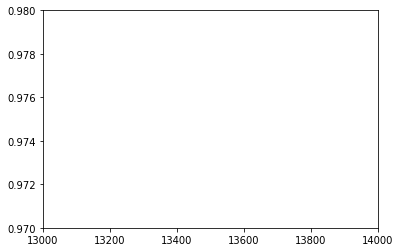

In [50]:
plt.plot(cumulative_x, cumulative_y)
plt.axis([13000, 14000, .97, .98])
print(cumulative_y[-1:])

In [53]:
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
  if index > vocab_size - 1:
    break
  else:
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
      embedding_matrix[index] = embedding_vector

In [54]:
print(embedding_matrix[2])

[-0.177       0.43200001  0.21391    -0.29515001  0.47343999 -0.38012999
  1.60179996  0.56238002  0.40478    -0.57094002  0.34154001  0.40245
 -5.07679987 -0.1568     -0.27046999 -0.71336001  0.50856    -0.25975999
 -0.47931999  0.60913002 -1.00300002 -1.02250004 -0.099247   -0.58947998
 -0.42467999]


In [55]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 25)          330000    
                                                                 
 bidirectional (Bidirectiona  (None, None, 50)         10200     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 50)               15200     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 24)                1224      
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 356,649
Trainable params: 26,649
Non-train

In [57]:
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 25s 19ms/step - loss: 0.6918 - accuracy: 0.5524 - val_loss: 0.6895 - val_accuracy: 0.5689
Epoch 2/30
719/719 [==============================] - 12s 17ms/step - loss: 0.6877 - accuracy: 0.5636 - val_loss: 0.6844 - val_accuracy: 0.5767
Epoch 3/30
719/719 [==============================] - 13s 18ms/step - loss: 0.6841 - accuracy: 0.5661 - val_loss: 0.6806 - val_accuracy: 0.5813
Epoch 4/30
719/719 [==============================] - 13s 17ms/step - loss: 0.6814 - accuracy: 0.5725 - val_loss: 0.6778 - val_accuracy: 0.5875
Epoch 5/30
719/719 [==============================] - 13s 18ms/step - loss: 0.6792 - accuracy: 0.5779 - val_loss: 0.6753 - val_accuracy: 0.5864
Epoch 6/30
719/719 [==============================] - 12s 17ms/step - loss: 0.6772 - accuracy: 0.5844 - val_loss: 0.6732 - val_accuracy: 0.6050
Epoch 7/30
719/719 [==============================] - 12s 17ms/step - loss: 0.6753 - accuracy: 0.5938 - val_loss: 0.6707 - val_accuracy:

It's learning almost nothing because we feeded the neural network with only 362 words :) . I couldn't find the original glove.twitter.27B.25D.txt file but I think this is a good notebook so I will keep it.

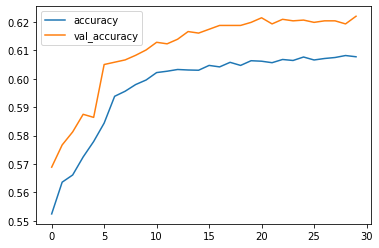

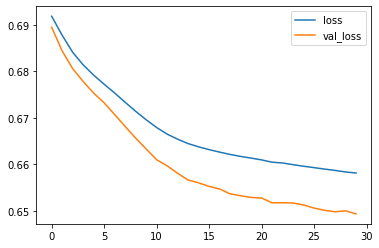

In [58]:
def plot_graphs(history, string):
  plt.plot(history.history[string]);
  plt.plot(history.history['val_'+string]);
  plt.legend([string, 'val_'+string]);
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [59]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_sentence(training_padded[2]))
print(training_sentences[2])
print(labels[2])

mom starting fear sons web series closest thing will grandchild ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?
mom starting fear sons web series closest thing will grandchild 
1


In [60]:
e = model.layers[0]
weights = e.get_weights()[0]
weights.shape # shape: (vocab_size, embedding_dim)

(13200, 25)

In [61]:
print(reverse_word_index[2])
print(weights[2])

new
[-0.177     0.432     0.21391  -0.29515   0.47344  -0.38013   1.6018
  0.56238   0.40478  -0.57094   0.34154   0.40245  -5.0768   -0.1568
 -0.27047  -0.71336   0.50856  -0.25976  -0.47932   0.60913  -1.003
 -1.0225   -0.099247 -0.58948  -0.42468 ]


In [62]:
test_sentences = ["It Was, For, Uh, Medical Reasons, Says Doctor To Boris Johnson, Explaining Why They Had To Give Him Haircut",
                  "It's a beautiful sunny day",
                  "I lived in Ireland, so in High School they made me learn to speak and write in Gaelic",
                  "Census Foot Soldiers Swarm Neighborhoods, Kick Down Doors To Tally Household Sizes"]
sequences = tokenizer.texts_to_sequences(test_sentences)
print(sequences)

padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(padded)

predictions = model.predict(padded)
print(predictions)

[[1, 1, 1, 10876, 1206, 535, 17, 772, 1, 13084, 1365, 4319, 1, 1, 1, 1, 171, 1, 4686], [1, 1, 431, 8073, 13], [1, 3617, 1, 6064, 1, 1, 92, 50, 1, 142, 1, 1005, 1, 1094, 1, 1663, 1, 1], [2717, 1234, 3025, 6172, 7042, 1910, 1, 4265, 1, 1, 5585, 5434]]
[[    1     1     1 10876  1206   535    17   772     1 13084  1365  4319
      1     1     1     1   171     1  4686     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    1     1   431  8073    13     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0]
 [    1  3617     1  6064     1     1    92    50     1   142     1  1005
      1  1094     1  1663     1     1     0     0     